In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# %cd /content/drive/MyDrive/summer2024/group project
# !ls

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(42)

In [3]:
# data = pd.read_csv('rawdata/sandiego.csv')
data = pd.concat([pd.read_csv('rawdata/sandiego.csv'), pd.read_csv('rawdata/losangeles.csv')])
# data.describe()

In [4]:
data = data[['name', 'description', 'neighborhood_overview','host_about', 'room_type', 'amenities', 'price', 'longitude', 'latitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'review_scores_rating', 'number_of_reviews']]

In [5]:
data.head()

,name,description,neighborhood_overview,host_about,room_type,amenities,price
0,North Park Craftsmen House * Great for Families,This Beautiful Craftsmen house has all the mod...,"We have the best Neighborhood in San Diego, in...",I am a San Diego based Entrepreneur with a lov...,Entire home/apt,"[""Hair dryer"", ""Children\u2019s bikes"", ""GE ga...",$199.00
1,Cozy Getaway Pacific Beach Oasis!,Your San Diego Oasis awaits!<br /><br />Privat...,NaN,I like to meet new people. I enjoy cooking and...,Private room,"[""Hair dryer"", ""Microwave"", ""Wifi"", ""Carbon mo...",$96.00
2,"Great home, 10 min walk to Beach","This 2 bedroom, 2 full bathroom home offers al...",NaN,We love living part of the year in San Diego. ...,Entire home/apt,"[""Free parking on premises"", ""Hair dryer"", ""Sh...",$227.00
3,"La Jolla Cottage, 3Blks 2 Ocean; 2bd1bth, Stei...",Tucked away from city streets are 3 patio gard...,"Tranquility, stately trees, meditative, zen-fu...","As a La Jolla native, I have seen many change...",Entire home/apt,"[""Ceiling fan"", ""Hair dryer"", ""Portable heater...",$191.00
4,Pacific Beach Cozy Private Hideaway Free Bikes,"Cozy Private Beach Retreat. 420 friendly, we h...","This is the best part of Pacific Beach, we are...","I have a wonderful home in Pacific Beach, Cali...",Entire home/apt,"[""Hair dryer"", ""Portable heater"", ""Self check-...",$115.00


In [6]:
# Drop duplicates based on all columns
data = data.drop_duplicates()

# Reset the index
data = data.reset_index(drop=True)
# Verify the result
print(data.index.unique().shape[0] == data.shape[0])
print(data.shape)

True
(57025, 16)


In [31]:
# data.dropna(inplace=True)
data.isnull().sum()

name                     0
description              0
neighborhood_overview    0
host_about               0
room_type                0
amenities                0
price                    0
longitude                0
latitude                 0
accommodates             0
bathrooms                0
bedrooms                 0
beds                     0
minimum_nights           0
review_scores_rating     0
number_of_reviews        0
dtype: int64

In [8]:
data = data.dropna(subset=['price', 'longitude', 'latitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'review_scores_rating', 'number_of_reviews'])
data = data.fillna('')
data = data.drop_duplicates()

In [9]:
print(data.index.unique().shape[0])
print(data.shape[0])

37116
37116


In [11]:
data['price'] = data['price'].str.replace('$', '').str.replace(',', '').astype(float)
def MinMaxScaler(data):
    MIN = data.min()
    MAX = data.max()
    return MIN, MAX, (data - MIN) / (MAX - MIN)
# MIN, MAX, data['price'] = MinMaxScaler(data['price'])

In [12]:
def remove_outliers_iqr(df, columns, th1=0.01, th3=0.90, multiplier=1.5):
    for column in columns:
        Q1 = df[column].quantile(th1)
        Q3 = df[column].quantile(th3)
        IQR = Q3 - Q1
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        print(f"column: {column}, lower_bound: {lower_bound}, upper_bound: {upper_bound}")
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df
# consider: Removing Outliers using Standard Deviation (probably not good because data is not normally distributed)
# cleaned_data columns: 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365','number_of_reviews_ltm'
data = remove_outliers_iqr(data,['price','longitude', 'latitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'review_scores_rating', 'number_of_reviews'],th3=0.8, multiplier=1.5)

column: price, lower_bound: -417.5, upper_bound: 794.5
column: longitude, lower_bound: -120.74035926414197, upper_bound: -115.15610015976338
column: latitude, lower_bound: 30.5607735, upper_bound: 36.2337471
column: accommodates, lower_bound: -6.5, upper_bound: 13.5
column: bathrooms, lower_bound: -0.5, upper_bound: 3.5
column: bedrooms, lower_bound: -3.0, upper_bound: 5.0
column: beds, lower_bound: -4.5, upper_bound: 7.5
column: minimum_nights, lower_bound: -42.5, upper_bound: 73.5
column: review_scores_rating, lower_bound: 0.0, upper_bound: 8.0
column: number_of_reviews, lower_bound: -141.5, upper_bound: 238.5


In [13]:
minmax = {}
for c in ['price','longitude', 'latitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'review_scores_rating', 'number_of_reviews']:
    minn, maxx, data[c] = MinMaxScaler(data[c])
    minmax[c] = (minn, maxx)

In [14]:
minmax

{'price': (6.0, 793.0),
 'longitude': (-118.91246, -116.936852),
 'latitude': (32.54076, 34.79182),
 'accommodates': (1, 13),
 'bathrooms': (0.0, 3.5),
 'bedrooms': (0.0, 5.0),
 'beds': (0.0, 7.0),
 'minimum_nights': (1, 70),
 'review_scores_rating': (1.0, 5.0),
 'number_of_reviews': (1, 238)}

In [15]:
data[['price', 'longitude', 'latitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'review_scores_rating', 'number_of_reviews']].describe()

,price,longitude,latitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,review_scores_rating,number_of_reviews
count,31863.000000,31863.000000,31863.000000,31863.000000,31863.000000,31863.000000,31863.000000,31863.000000,31863.000000,31863.000000
mean,0.248816,0.453433,0.527686,0.248232,0.403329,0.320359,0.275192,0.167556,0.949063,0.172802
std,0.181187,0.257548,0.254785,0.197152,0.181624,0.203693,0.211022,0.199193,0.093542,0.222769
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.119441,0.271076,0.190013,0.083333,0.285714,0.200000,0.142857,0.014493,0.937500,0.016878
50%,0.195680,0.334024,0.656153,0.250000,0.285714,0.200000,0.285714,0.028986,0.975000,0.075949
75%,0.318933,0.827090,0.689913,0.416667,0.571429,0.400000,0.428571,0.420290,1.000000,0.244726
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
# prompt: vocabs = [], for each columns, split the strings by all punctuation marks and ' ', append every word to vocabs. assign the cell values with splitted words

import re

# Initialize an empty list to store vocabulary words
vocabs = []
new_data = [] # Initialize an empty list to store the processed data

# List of columns to process
columns = ['name', 'description', 'neighborhood_overview', 'host_about', 'room_type', 'amenities']



# for col in columns:
#     new_col = []
#     for i in range(len(data[col])):
#       cell_value = data[col][i]
#       if pd.isna(cell_value):
#           new_col.append([])
#       elif isinstance(cell_value, str):
#         words = re.split(r'[,\s.;!?\'\"\[\]\(\)\{\}*/-]+', cell_value)
#         words = [word.lower() for word in words if word]
#         for word in words:
#             if word not in vocabs:
#                 vocabs.append(word)
#         new_col.append(words)
#     new_data.append(new_col)

stop_words = {'the', 'is', 'in', 'it', 'and', 'to', 'of', 'a', 'that', 'with', 'as', 'for', 'on', 'this', 'by', 'an', 'at', 'or', 'from'}

def parse_words(cell_value, stop_words, htmls=['<br>', '</br>', '<p>', '</p>']):
    """
    Parse words from a given cell value, remove stop words and empty strings,
    and convert words to lowercase.

    Parameters:
    - cell_value (str): The text to be parsed.
    - stop_words (set): A set of stop words to be removed from the text.
    - htmls (list): A list of HTML tags to be replaced with spaces.

    Returns:
    - filtered_words (list): A list of parsed and filtered words.
    """
    # Replace HTML tags with spaces
    cell_value = re.sub(r"[^\w\s-]", " ", cell_value) 
    for html_tag in htmls:
        cell_value = cell_value.replace(html_tag, ' ')
    
    # Split the cell value into words using the specified delimiters
    # words = re.split(r"[\,\.\;\!\?\"\[\]\(\)\{\}\*\/\\\-\+\~]", cell_value)
    words = re.split(r"[,\s.;!?\"\[\]\(\)\{\}*/\\\-]+", cell_value)
    
    # Remove stop words and empty strings, and convert to lowercase
    filtered_words = [word.lower() for word in words if word.lower() not in stop_words and word != '']

    return filtered_words

In [20]:
print(parse_words("as@oc, !!laksw --fas ''oiwne",stop_words))

['oc', 'laksw', 'fas', 'oiwne']


In [21]:

# Process data row by row
for idx, row in data.iterrows():
    new_row = []  # Initialize a new list to store processed words for the current row
    for col in columns:
        cell_value = row[col]  # Get the cell value for the current column and row
        if pd.isna(cell_value):
            new_row.append([])
        else:
            if isinstance(cell_value, str):
                words = parse_words(cell_value, stop_words)
                for word in words:
                  vocabs.append(word.lower())  # Add the word to the vocabulary list in lowercase
                  new_row.append(word.lower())  # Add the word to the current row list in lowercase
    new_data.append(new_row)  # Add the processed row to the new_data list

In [22]:
vocabs = set(vocabs)
print(f"Total unique words: {len(vocabs)}")

Total unique words: 37614


In [23]:
print(vocabs)

{'habberton', 'bell', '400sq', 'daily', '我叫林韦恩', 'racist', 'aracdia', 'arsineh', '22mins', '900k', 'champion', '出入便捷', 'thailand', 'barista', 'gujarati', 'medellin', 'lattissimo', 'dip', 'realms', 'positively', 'fatty', 'marmount', 'battleship', 'vdl', 'minfrm', 'prospect', 'univercial', '617561', 'youtube', 'sanitized', '13mi', 'whitwood', '218', 'kaws', 'galleri', 'cravings', 'bandera', '261', 'sword', 'suntanning', 'caliber', 'wework', 'san11', 'expressways', 'lucky', 'guitarist', 'mainhouse', 'disneylandated', 'magical', '466', 'stubhub', 'caught', 'sailboats', 'thuan', 'strauss', '464', 'ciel', 'mercato', 'renew', 'osmose', 'banks', 'covell', 'plein', 'whaley', 'focused', 'boeing', 'blankets', 'airbandb', '独立式别墅', 'mitsuwa', 'somethings', 'reduction', '5_windsor', 'reign', 'corporatio', 'tecolate', 'kindle', 'disruption', 'cbd', 'totarget', 'pilgrimages', '234373', 'booster', 'formosa', 'evergreen', '351', 'embellishments', 'quonset', 'fault', 'agenda', 'hearts', 'optionally', 've

In [ ]:
# vocabs_list = list(vocabs)
# print(vocabs_list)

In [25]:
print(new_data[1021])

['guest', 'studio', 'ocean', 'lagoon', 'views', 'walk', 'beach', 'beautiful', 'spacious', 'comfortable', 'private', 'studio', 'private', 'view', 'deck', 'walking', 'distance', 'beach', 'torrey', 'pines', 'reserve', 'fine', 'restaurants', 'downtown', 'del', 'mar', 'nearby', 'del', 'mar', 'racetrack', 'are', 'approximately', '3', 'miles', 'away', 'br', 'exceptional', 'piece', 'property', 'located', 'end', 'quiet', 'cul', 'de', 'sac', 'next', 'nature', 'reserve', 'br', 'unit', 'fully', 'furnished', 'stocked', 'convenience', 'items', 'such', 'iron', 'ironing', 'board', 'hair', 'dryer', 'luxurious', 'bedding', 'br', 's', 'perfect', 'couples', 'retreat', 'del', 'mar', 'terrace', 'great', 'funky', 'walkable', 'neighborhood', 'access', 'variety', 'great', 'restaurants', 'beach', 'i', 'm', 'semi', 'retired', 'landscape', 'architect', 'my', 'partner', 'i', 'are', 'quiet', 'strive', 'be', 'conscientious', 'respectful', 'your', 'space', 'while', 'you', 're', 'here', 'course', 'we', 'are', 'also', 

In [26]:
word_to_idx = {word: idx for idx, word in enumerate(vocabs)}
idx_to_word = {idx: word for idx, word in enumerate(vocabs)}

In [27]:
def one_hot_encode_sentence(sentence, word_to_idx):
  encoded_sentence = np.zeros(len(word_to_idx))
  for word in sentence:
    encoded_sentence[word_to_idx[word]] += 1
  return encoded_sentence

def one_hot_encode(data, word_to_idx):
  vocab_size = len(word_to_idx)
  encoded_data = np.zeros((len(data), vocab_size))
  for row in range(len(data)):
    for word in data[row]:
      encoded_data[row][word_to_idx[word]] += 1
  return encoded_data

In [28]:
# max len of a row
max = 0
for row in new_data:
  if len(row) > max:
    max = len(row)
print(max)

1040


In [29]:
# Initialize an empty list to store the encoded data
# for row in new_data:
#   new_row = [0] * CONTEXT_SIZE
#   i = 0 # counter to keep track of the current position in new_row
#   for word in row:
#     new_row[i] = (word_to_idx[word]) # Map the word to its index and store it in new_row
#     i+=1
#     if i == CONTEXT_SIZE: # If we reach CONTEXT_SIZE, stop adding more words
#       break
#   encoded_data.append(new_row)

encoded_data = np.array([one_hot_encode_sentence(row, word_to_idx) for row in new_data])

In [30]:
encoded_data.shape

(31863, 37614)

In [32]:


# Normalize y
y_np = data[['price', 'longitude', 'latitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'review_scores_rating', 'number_of_reviews']].values # Convert to numpy array

y = torch.tensor(y_np, dtype=torch.float32)
encoded_data_tensor = torch.tensor(encoded_data, dtype=torch.float32)

# Move data to the device
# encoded_data = encoded_data.to(device)
# y = y.to(device)

# Create TensorDataset
dataset = torch.utils.data.TensorDataset(encoded_data_tensor, y)

# Shuffle dataset and split into training and testing sets
def train_test_split_tensor(dataset, test_size=0.2, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    
    # Shuffle indices
    indices = np.arange(len(dataset))
    np.random.shuffle(indices)
    
    # Split indices
    split_idx = int(len(dataset) * (1 - test_size))
    train_indices = indices[:split_idx]
    test_indices = indices[split_idx:]
    
    # Create datasets
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    test_dataset = torch.utils.data.Subset(dataset, test_indices)
    
    return train_dataset, test_dataset

# Split dataset
train_dataset, test_dataset = train_test_split_tensor(dataset, test_size=0.2, random_state=42)

# Create DataLoaders for training and testing datasets
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=False)

In [33]:
VOCAB_SIZE = len(vocabs) # size of the vocabulary
CONTEXT_SIZE = 1500 # the maximum number of words to consider in each context (row)
EMBEDDING_DIM = 400 # dimensionality of the embedding vectors

In [34]:
class simpleNN(nn.Module):
  def __init__(self):
    super(simpleNN, self).__init__()
    self.fc1 = nn.Linear(VOCAB_SIZE, EMBEDDING_DIM)
    self.fc2 = nn.Linear(EMBEDDING_DIM, 10)
    self.relu = nn.ReLU()
  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.relu(self.fc2(x))
    # x = self.fc2(x)
    return x

In [35]:
losses = []
loss_function = nn.MSELoss()
model = simpleNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [36]:
def train_model(model, train_loader, val_loader, num_epochs=10):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0

        for inputs, targets in train_loader:
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_function(outputs.squeeze(), targets)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item() * len(inputs)

        # Average training loss for the epoch
        epoch_train_loss /= len(train_loader)
        train_losses.append(epoch_train_loss)

        # Validation
        model.eval()  # Set the model to evaluation mode
        epoch_val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                # Forward pass
                outputs = model(inputs)
                loss = loss_function(outputs.squeeze(), targets)

                epoch_val_loss += loss.item() * len(inputs)

        # Average validation loss for the epoch
        epoch_val_loss /= len(val_loader)
        val_losses.append(epoch_val_loss)

        # Print epoch summary
        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

    return train_losses, val_losses


In [37]:
num_epochs = 10  # Set the number of epochs
train_losses, val_losses = train_model(model, train_dataloader, test_dataloader, num_epochs=num_epochs)

Epoch 1/10 - Train Loss: 20.5663, Val Loss: 11.0566
Epoch 2/10 - Train Loss: 8.8895, Val Loss: 9.7253
Epoch 3/10 - Train Loss: 6.6641, Val Loss: 9.3440
Epoch 4/10 - Train Loss: 5.3440, Val Loss: 9.2927
Epoch 5/10 - Train Loss: 4.4190, Val Loss: 9.3554
Epoch 6/10 - Train Loss: 3.7968, Val Loss: 9.4820
Epoch 7/10 - Train Loss: 3.2493, Val Loss: 9.6134
Epoch 8/10 - Train Loss: 2.8502, Val Loss: 9.8017
Epoch 9/10 - Train Loss: 2.5489, Val Loss: 9.8992
Epoch 10/10 - Train Loss: 2.2911, Val Loss: 10.0725


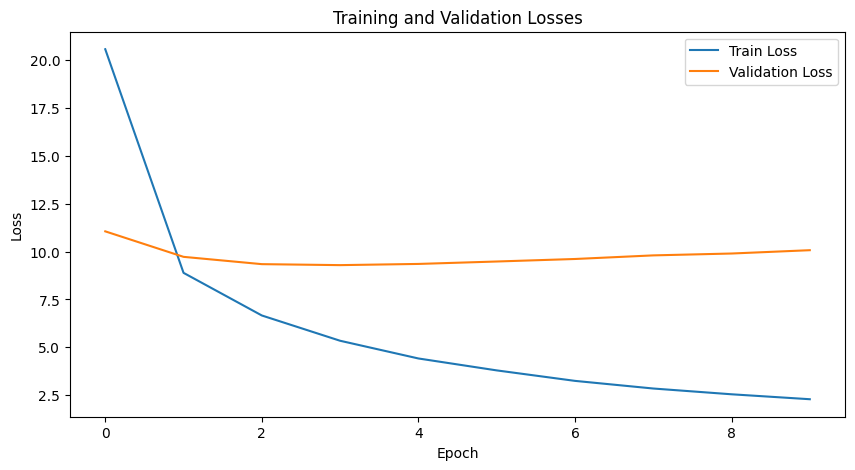

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [39]:
def get_vector(word, word_to_idx, model):
    """
    Retrieve the embedding vector for a given word from the weights of fc1 in the model.
    
    Parameters:
    - word (str): The word whose embedding vector is to be retrieved.
    - word_to_idx (dict): Dictionary mapping words to their indices.
    - model (torch.nn.Module): The neural network model containing the fc1 layer.
    
    Returns:
    - torch.Tensor: The embedding vector for the given word.
    """
    # Ensure the word is in the vocabulary
    if word not in word_to_idx:
        raise ValueError(f"Word '{word}' not found in vocabulary.")
    
    # Convert the word to its index
    word_idx = word_to_idx[word]
    
    # Retrieve the embedding vector from the fc1 weights
    # model.fc1.weight is of shape (VOCAB_SIZE, EMBEDDING_DIM)
    # We need the row corresponding to the word index
    embedding_vector = model.fc1.weight.T[word_idx]
    
    return embedding_vector
 

In [40]:
def find_closest_words_from_vector(word_vector, idx_to_word, model, num_w):
    # Get all word vectors
    all_vectors = model.fc1.weight.T
    
    # Compute cosine similarities between the word vector and all other vectors
    similarities = F.cosine_similarity(word_vector.unsqueeze(0), all_vectors)
    
    # Get the indices of the top `num_w` most similar vectors
    _, top_indices = similarities.topk(num_w + 1)  # +1 to exclude the word itself
    
    print(f"Closest words':")
    for idx in top_indices[1:]:  # Skip the first index, which is the word itself
        word_idx = idx.item()
        print(f"Index: {word_idx}, Word: {idx_to_word[word_idx]}")

In [41]:
def find_closest_words(word, word_to_idx, idx_to_word, model, num_w):
    """
    Find and print the closest words to a given word based on their embedding vectors.
    
    Args:
    - word (str): The word to find closest words for.
    - word_to_idx (dict): Mapping from words to indices.
    - idx_to_word (dict): Mapping from indices to words.
    - model (torch.nn.Module): The model containing the embedding weights.
    - num_w (int): Number of closest words to find.
    """
    word_vector = get_vector(word, word_to_idx, model)
    
    # Get all word vectors
    all_vectors = model.fc1.weight.T
    
    # Compute cosine similarities between the word vector and all other vectors
    similarities = F.cosine_similarity(word_vector.unsqueeze(0), all_vectors)
    
    # Get the indices of the top `num_w` most similar vectors
    _, top_indices = similarities.topk(num_w + 1)  # +1 to exclude the word itself
    
    print(f"Closest words to '{word}':")
    for idx in top_indices[1:]:  # Skip the first index, which is the word itself
        word_idx = idx.item()
        print(f"Index: {word_idx}, Word: {idx_to_word[word_idx]}")

In [45]:
find_closest_words('fish', word_to_idx, idx_to_word, model, 10)

Closest words to 'fish':
Index: 3888, Word: g
Index: 15140, Word: nautilus
Index: 16884, Word: mkts
Index: 33761, Word: deputy
Index: 35482, Word: trustworthy
Index: 29396, Word: seafront
Index: 1786, Word: refrigerators
Index: 15732, Word: fws
Index: 4819, Word: entr
Index: 15565, Word: hook


In [50]:
ex = get_vector('ucsd', word_to_idx, model) - get_vector('diego', word_to_idx, model) + get_vector('angeles', word_to_idx, model)
print(find_closest_words_from_vector(ex, idx_to_word, model, 10))

Closest words to 'conditioning':
Index: 3844, Word: angeles
Index: 31998, Word: la
Index: 36519, Word: los
Index: 1815, Word: hospital
Index: 26521, Word: markets
Index: 24768, Word: l
Index: 36710, Word: dtla
Index: 12138, Word: valley
Index: 520, Word: 7
Index: 27753, Word: farmer
None


In [51]:
def restore_price(p):
    MIN, MAX= minmax['price']
    return p * (MAX - MIN) + MIN

In [55]:
try:
    random_n = np.random.randint(0, len(new_data))
    print(random_n)
    print(data.iloc[random_n])
    # print(new_data[random_n])
    s1 = restore_price(data['price'][random_n])
    s2 = model(torch.tensor(one_hot_encode_sentence(new_data[random_n], word_to_idx), dtype=torch.float32))
    # print(s2)
    print(f"og price: {s1}, predict price: {restore_price(s2[1])}")
except: print('something wrong with accessing data[price]')

16183
name                                                        The Sawtelle 7
description              Welcome home to this beautiful  upper one bedr...
neighborhood_overview                                                     
host_about                                                                
room_type                                                  Entire home/apt
amenities                ["Free street parking", "Refrigerator", "Dryer...
price                                                             0.081321
longitude                                                         0.248136
latitude                                                          0.655158
accommodates                                                      0.083333
bathrooms                                                         0.285714
bedrooms                                                               0.2
beds                                                              0.142857
minimum_nights     

In [56]:
a = model(torch.tensor(one_hot_encode_sentence(parse_words('heavenly beautiful 2 beds 3 baths swimming pool ultimate chill lots of cats and delicious food', stop_words), word_to_idx), dtype=torch.float32))
print(restore_price(a[0].item()))
b = model(torch.tensor(one_hot_encode_sentence(parse_words('ugly hot hell 3 bed 1 bath full of tears and regrets', stop_words), word_to_idx), dtype=torch.float32))
print(restore_price(b[0].item()))

117.3760824650526
51.0775776989758


tensor(0.0199)


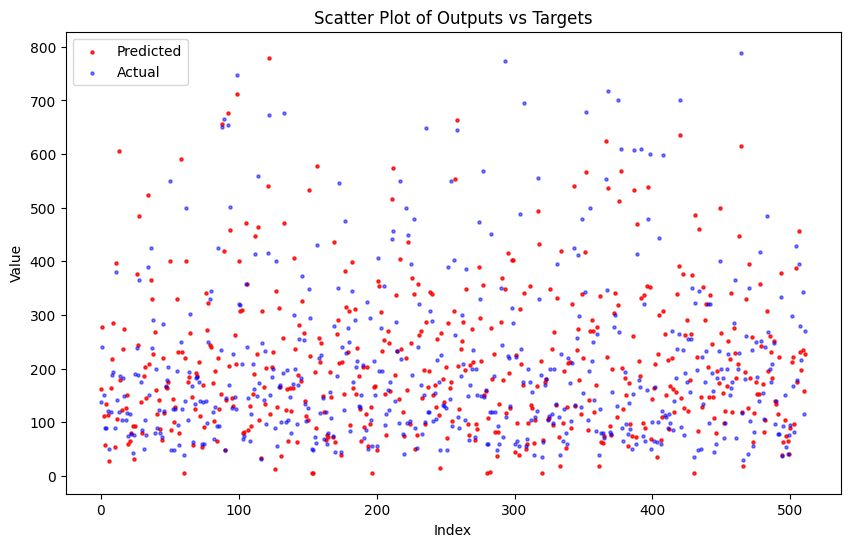

In [57]:
model.eval()  # Set the model to evaluation mode
start = 10001
end = 10002
all_outputs = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        # Forward pass
        outputs = model(inputs)
        # print(i, outputs, targets)
        loss = loss_function(outputs.squeeze(), targets)
        print(loss)
        # print(targets.shape, outputs[:,0].shape)
        # Store the outputs, targets, and indices for plotting
        all_outputs.extend(outputs[:,0].cpu().numpy())
        all_targets.extend(targets[:,0].cpu().numpy())
        
        start += 1
        if start == end:
            break
        
# Convert lists to numpy arrays for plotting
all_outputs = restore_price(np.array(all_outputs))
all_targets = restore_price(np.array(all_targets))
size = np.arange(all_outputs.shape[0])

# Scatter plot of outputs vs targets
plt.figure(figsize=(10, 6))
point_size = 5
plt.scatter(size, all_outputs, color='r', label='Predicted',alpha=0.8, s=point_size)
plt.scatter(size, all_targets, color='b', label='Actual', alpha=0.5,s=point_size)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Plot of Outputs vs Targets')
plt.legend()
plt.show()



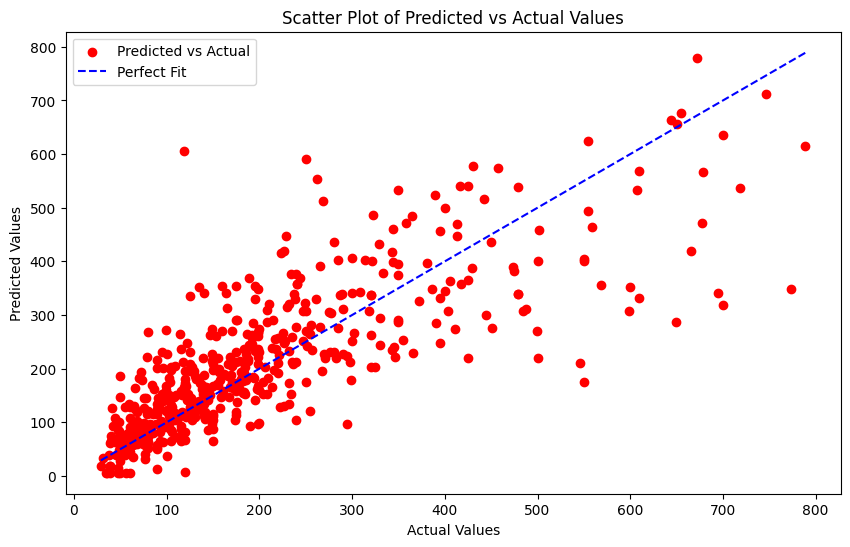

In [58]:
# Scatter plot of all_outputs vs all_targets
plt.figure(figsize=(10, 6))
plt.scatter(all_targets, all_outputs, color='r', label='Predicted vs Actual')
min_val = np.min(all_targets)
max_val = np.max(all_targets)
plt.plot([min_val, max_val], [min_val, max_val], 'b--', label='Perfect Fit')  # Diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Predicted vs Actual Values')
plt.legend()
plt.show()

In [59]:
torch.save(model.state_dict(), 'we_model3')

In [ ]:
start = 623
end = 624

with torch.no_grad():
    for inputs, targets in test_dataloader:
        # Forward pass
        outputs = model(inputs)
        # print(i, outputs, targets)
        # loss = loss_function(outputs.squeeze(), targets)
        # print(loss)
        for i in zip(targets, outputs):
            print(i[0])
            print(i[1])
            print()

        
        start += 1
        if start == end:
            break